# Dynamics 365 Business Central Troubleshooting Guide (TSG) - Login issues (SaaS)

This notebook contains Kusto queries that can help getting to the root cause of a login issue for an environment in the online version of Business Central (SaaS). Each section in the notebook contains links to the TSG part of the authorization telemetry documentation in [aka.ms/bctelemetry](aka.ms/bctelemetry), as well as Kusto queries that help dive into a specific area. 

NB! The signal used in this notebook is only available in version 16.2 (or newer) of Business Central online, so check the version of your environment.

## 1\. Get setup: Load up Python libraries and connect to Application Insights
First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it? ) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


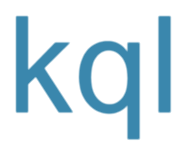

In [14]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [15]:
# Connect to the Application Insights API
%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'

## 2\. Define filters

This workbook is designed for troubleshooting a single environment. Please provide values for aadTenantId and environmentName (or use a config file).

In [16]:
# Add values for AAD tenant id, environment name, and date range.
# It is possible to leave the value for AAD tenant id or environment name blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:\\tmp\\notebook.ini"


# Add AAD tenant id and environment name here (or leave blank)
aadTenantId = ""
environmentName = ""

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2021-11-01"
endDate = "2022-01-01"




# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         
environmentName     
startDate           2021-11-01
endDate             2022-01-01


# Analyze the login flow
Now you can run Kusto queries to look for possible root causes for login issues.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

Documentation of the authentication and authorization flow: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/security/security-application

Kusto sample: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Authorization.kql

## Authentication

Authentication in the online version of Business Central happens strictly in Azure Active Directory (AAD). Only when a user is authenticated in AAD, a session is attempted to be created in the Business Central server (NST). When dealing with login issues, check for *absense* of signal in eventIds for Authorization in the pre-open company of opening a session in the NST (eventIds RT0001 and RT0003) to determine if the issue is related to AAD (e.g. user is disabled, wrong password, failed MFA) or maybe something happening in the customer network (could be a DNS issue, or a changed firewall rule). 

**If you do not see any signal for eventIds RT0001 and RT0003, then start troubleshooting network issues first.**

Read more in the Security Guide here: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/security/security-application#authentication

In [17]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId in ('RT0001', 'RT0003' )
| summarize request_count=count() by bin(timestamp, 1h) | render timechart title= 'Number of pre-open company authorization attempts in the last day'

[]

## Authorization failures (pre-open company)

A user can fail authorization before the open company trigger is executed for a number of different reasons:
* The user was successfully authenticated in Azure Active Directory but the user account is disabled in Business Central.
* A user successfully authenticated in Azure Active Directory but the user does not have any entitlements in Business Central (license issue)

Read more about these types of failures in the authorization signal docs here: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-authorization-trace#authorizationfailedpreopencompany

Kusto query: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Authorization.kql

In [18]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0001'
| project timestamp
, guestUser = customDimensions.guestUser
, userType = customDimensions.userType
, failureReason = customDimensions.failureReason
, entitlementSetIds = customDimensions.entitlementSetIds
| order by timestamp desc
| limit 100

,timestamp,guestUser,userType,failureReason,entitlementSetIds


[]

## Authorization failures (in the open company process)

Events show up here for a number of different reasons
* The company name is invalid
* User has no permission to access the company
* The environment is locked
* The license has expired or the trial period has ended
* The user's license is not valid for use on production companies

Read more in the authorization signal docs here: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-authorization-trace#authorization-failed-open-company

Kusto query: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Authorization.kql


In [19]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0002'
| project timestamp
, clientType = customDimensions.clientType
, companyName = customDimensions.companyName
, failureReason = customDimensions.failureReason
| order by timestamp desc
| limit 100

,timestamp,clientType,companyName,failureReason


[]

## Successful logins (authentication in AAD succeded, authorization in the Business Central server succeeded)

If the user can authenticate against AAD and the two authorization steps inside the Business Central server succeeds, then a session is created and the user has successfully logged in.

Read more about application security in the Security Guide here:  https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/security/security-application#authentication

Kusto query: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Authorization.kql

In [20]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0004'
| project timestamp
, clientType = customDimensions.clientType
, companyName = customDimensions.companyName
, totalTimeInMS = toreal(totimespan(customDimensions.totalTime))/10000 // totalTime is measured in ticks, divide by 10000 to get milliseconds
| order by timestamp desc
| limit 100

,timestamp,clientType,companyName,totalTimeInMS
0,2021-12-09 01:09:28.184000+00:00,ChildSession,CRONUS International Ltd.,1.1000
1,2021-12-09 01:09:27.152000+00:00,Background,CRONUS International Ltd.,12.1472
2,2021-12-09 01:09:19.149000+00:00,WebClient,CRONUS International Ltd.,6667.4392
3,2021-11-10 12:57:52.906000+00:00,Background,CRONUS International Ltd.,3.6174
4,2021-11-10 12:57:50.094000+00:00,Background,CRONUS International Ltd.,10630.9501
5,2021-11-10 12:57:50.094000+00:00,Background,CRONUS International Ltd.,10630.4960
6,2021-11-08 20:46:53.175000+00:00,Background,CRONUS International Ltd.,2.9601
7,2021-11-08 20:46:50.644000+00:00,Background,CRONUS International Ltd.,7418.9702
8,2021-11-08 20:46:50.644000+00:00,Background,CRONUS International Ltd.,7419.8216
9,2021-11-07 20:57:01.501000+00:00,Background,CRONUS International Ltd.,2.2338


[{'timestamp': datetime.datetime(2021, 12, 9, 1, 9, 28, 184000, tzinfo=tzutc()), 'clientType': 'ChildSession', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 1.1},
 {'timestamp': datetime.datetime(2021, 12, 9, 1, 9, 27, 152000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 12.1472},
 {'timestamp': datetime.datetime(2021, 12, 9, 1, 9, 19, 149000, tzinfo=tzutc()), 'clientType': 'WebClient', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 6667.4392},
 {'timestamp': datetime.datetime(2021, 11, 10, 12, 57, 52, 906000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 3.6174},
 {'timestamp': datetime.datetime(2021, 11, 10, 12, 57, 50, 94000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 10630.9501},
 {'timestamp': datetime.datetime(2021, 11, 10, 12, 57, 50, 94000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 10630.496},
 {'timestamp': datetime.datetime(2021, 11, 8, 20, 46, 53, 175000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 2.9601},
 {'timestamp': datetime.datetime(2021, 11, 8, 20, 46, 50, 644000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 7418.9702},
 {'timestamp': datetime.datetime(2021, 11, 8, 20, 46, 50, 644000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 7419.8216},
 {'timestamp': datetime.datetime(2021, 11, 7, 20, 57, 1, 501000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 2.2338},
 {'timestamp': datetime.datetime(2021, 11, 7, 20, 56, 27, 433000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 2.5455},
 {'timestamp': datetime.datetime(2021, 11, 7, 20, 56, 19, 999000, tzinfo=tzutc()), 'clientType': 'WebClient', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 1417.9688},
 {'timestamp': datetime.datetime(2021, 11, 6, 19, 47, 25, 658000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 3.4127},
 {'timestamp': datetime.datetime(2021, 11, 6, 19, 47, 22, 754000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 8004.4742},
 {'timestamp': datetime.datetime(2021, 11, 6, 19, 47, 22, 754000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 4615.711},
 {'timestamp': datetime.datetime(2021, 11, 5, 19, 47, 16, 331000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 2.2262},
 {'timestamp': datetime.datetime(2021, 11, 5, 19, 47, 11, 347000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 2.403},
 {'timestamp': datetime.datetime(2021, 11, 5, 19, 47, 10, 330000, tzinfo=tzutc()), 'clientType': 'Background', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 2.4149},
 {'timestamp': datetime.datetime(2021, 11, 5, 14, 18, 23, 665000, tzinfo=tzutc()), 'clientType': 'ChildSession', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 1.8854},
 {'timestamp': datetime.datetime(2021, 11, 5, 14, 18, 15, 574000, tzinfo=tzutc()), 'clientType': 'WebClient', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 5852.6887},
 {'timestamp': datetime.datetime(2021, 11, 5, 13, 53, 7, 551000, tzinfo=tzutc()), 'clientType': 'ChildSession', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 0.9626},
 {'timestamp': datetime.datetime(2021, 11, 5, 13, 53, 6, 854000, tzinfo=tzutc()), 'clientType': 'WebClient', 'companyName': 'CRONUS International Ltd.', 'totalTimeInMS': 15.5036},

In [21]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0004'
| extend clientType = tostring( customDimensions.clientType )
| summarize count=count() by clientType, bin(timestamp, 1h)
| render timechart title= 'Number of successful logins the last day (shown by client/session type)'

[{'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 12, 9, 1, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 12, 9, 1, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 12, 9, 1, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 10, 12, 0, tzinfo=tzutc()), 'count': 3},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 6, 19, 0, tzinfo=tzutc()), 'count': 3},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 4, 22, 0, tzinfo=tzutc()), 'count': 5},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 4, 22, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 4, 22, 0, tzinfo=tzutc()), 'count': 5},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 3, 21, 0, tzinfo=tzutc()), 'count': 4},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 3, 21, 0, tzinfo=tzutc()), 'count': 4},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 3, 21, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 4, 21, 0, tzinfo=tzutc()), 'count': 2},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 4, 21, 0, tzinfo=tzutc()), 'count': 2},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 4, 19, 0, tzinfo=tzutc()), 'count': 4},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 4, 19, 0, tzinfo=tzutc()), 'count': 2},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 4, 19, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 4, 20, 0, tzinfo=tzutc()), 'count': 6},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 4, 20, 0, tzinfo=tzutc()), 'count': 6},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 4, 20, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 7, 20, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 7, 20, 0, tzinfo=tzutc()), 'count': 2},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 8, 20, 0, tzinfo=tzutc()), 'count': 3},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 3, 18, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 3, 18, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 3, 18, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 5, 13, 0, tzinfo=tzutc()), 'count': 2},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 5, 13, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 5, 13, 0, tzinfo=tzutc()), 'count': 2},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 5, 14, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 5, 14, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 5, 19, 0, tzinfo=tzutc()), 'count': 3},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 11, 4, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 11, 4, 0, 0, tzinfo=tzutc()), 'count': 7},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 11, 4, 0, 0, tzinfo=tzutc()), 'count': 1}]

In [22]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId in ('RT0001', 'RT0002', 'RT0004')
| extend attemptType = case(
    customDimensions.eventId == 'RT0001', 'Failure before open company' ,
    customDimensions.eventId == 'RT0002', 'Failure in open company trigger' ,
    customDimensions.eventId == 'RT0004', 'Successful login' , 
    'Unknown reason'
)
| summarize count=count() by attemptType, bin(timestamp, 1h)
| render timechart title= 'Number of login attempts the last day (shown by success/failure)'

[{'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 12, 9, 1, 0, tzinfo=tzutc()), 'count': 3},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 6, 19, 0, tzinfo=tzutc()), 'count': 3},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 4, 21, 0, tzinfo=tzutc()), 'count': 4},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 3, 21, 0, tzinfo=tzutc()), 'count': 9},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 4, 22, 0, tzinfo=tzutc()), 'count': 11},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 4, 19, 0, tzinfo=tzutc()), 'count': 7},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 4, 20, 0, tzinfo=tzutc()), 'count': 13},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 7, 20, 0, tzinfo=tzutc()), 'count': 3},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 10, 12, 0, tzinfo=tzutc()), 'count': 3},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 5, 13, 0, tzinfo=tzutc()), 'count': 5},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 5, 14, 0, tzinfo=tzutc()), 'count': 2},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 5, 19, 0, tzinfo=tzutc()), 'count': 3},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 4, 0, 0, tzinfo=tzutc()), 'count': 9},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 8, 20, 0, tzinfo=tzutc()), 'count': 3},
 {'attemptType': 'Successful login', 'timestamp': datetime.datetime(2021, 11, 3, 18, 0, tzinfo=tzutc()), 'count': 3}]